In [1]:
# -*- coding: utf-8 -*-
import multiprocessing
import pickle
import time
time.clock= time.time
import sys

from scipy.special import polygamma as pg
from scipy.special import psi as psi

import numpy as np

SMALL_NUMBER = 1e-100

# This is the LDA implementation to use
# K = number of topics
# eta = hyperparameter for topics (i.e. pseudo word counts)
# alpha = initial Dirichlet hyperparameter
# update_alpha = boolean to determine whether or not alpha is updated at each iteration
# word_index is a dictionary storing the position of each feature in numpy arrays
 # word_index is only used in multi-file as it's important that features are always in the same order.
 # In single file it is created internally
class VariationalLDA(object):
    def __init__(self,corpus=None,K = 20,eta=0.1,
        alpha=1,update_alpha=True,word_index=None,normalise = -1,fixed_topics = None,fixed_topics_metadata = None,
        topic_index = None,top_verbose = True):
        self.corpus = corpus
        self.word_index = word_index
        self.normalise = normalise
        #  If the corpus exists, make the word index and the (unused?) word doc matrix
        if not self.corpus == None:
            self.n_docs = len(self.corpus)
            if self.word_index == None:
                self.word_index = self.find_unique_words()
            if top_verbose:
                print ("Object created with {} documents".format(self.n_docs))
            self.n_words = len(self.word_index)
            self.make_doc_index()
            if self.normalise > -1:
                if top_verbose:
                    print ("Normalising intensities")
                #self.normalise_intensities()
        
        self.K = K

        if fixed_topics:
            self.n_fixed_topics = len(fixed_topics)
            self.K += self.n_fixed_topics
        else:
            self.n_fixed_topics = 0


        self.alpha = alpha
        #  If alpha is a single value, make it into a vector
        if type(self.alpha) == int or type(self.alpha) == float:
            self.alpha = self.alpha*np.ones(self.K)
        self.eta = eta # Smoothing parameter for beta
        self.update_alpha = update_alpha
        self.doc_metadata = None
        

        # self.topic_index = topic_index
        # self.topic_metadata = topic_metadata
        self.topic_index = topic_index
        if not self.topic_index:
            self.topic_index = {}
            self.topic_metadata = {}
            topic_pos = 0
            if fixed_topics:
                for topic_name in fixed_topics:
                    self.topic_index[topic_name] = topic_pos
                    #self.topic_metadata[topic_name] = fixed_topics_metadata[topic_name]
                    #self.topic_metadata[topic_name]['type'] = 'fixed'
                    topic_pos += 1
        
            for topic_pos in range(self.n_fixed_topics,self.K):
                topic_name = 'motif_{}'.format(topic_pos)
                #self.topic_index[topic_name] = topic_pos
                #self.topic_metadata[topic_name] = {'name':topic_name,'type':'learnt'}

        if fixed_topics:
            self._add_exact_fixed_topics(fixed_topics)
            

    def _add_exact_fixed_topics(self,fixed_topics):
        # first add any missing words
        #word_pos = max(self.word_index.values())+1

        #for topic,spectrum in fixed_topics.items():
         #   for word in spectrum:
          #      if not word in self.word_index:
           #         self.word_index[word] = word_pos
            #        word_pos += 1
        #self.n_words = len(self.word_index)

        # Now make the fixed rows of beta
        self.beta_matrix = np.zeros((self.K,self.n_words),np.float64) + SMALL_NUMBER
        #self.beta_matrix[0:50,:] = fixed_topics
        for topic_pos,spectrum in fixed_topics.items():
                for word_pos,val in spectrum.items():
                    self.beta_matrix[topic_pos,word_pos] = val
                self.beta_matrix[topic_pos,:] /= self.beta_matrix[topic_pos,:].sum()


    def create_word_index (self,df):
        word_index = {}
        pos = 0
        for word in list(df.T.columns):
            word_index[word] = pos
            pos += 1
        return word_index
   
    def create_doc_index (self,df):
        self.doc_index = {}
        doc_pos = 0
        for doc in list(df.T.index):
            self.doc_index[doc] = doc_pos
            doc_pos += 1
                
    def load_data_sc(self,df):
        print ("Edited")
        self.n_docs = df.T.shape[0]
        self.word_index = self.create_word_index(df)
        self.create_doc_index(df)
        self.n_words = df.T.shape[1]
        self.corpus = df.T.to_dict(orient="index")
        for doc in self.corpus.keys(): 
            self.corpus[doc] = {key:val for key, val in self.corpus[doc].items() if val != 0}
        
 
        
        
   
    # Run the VB inference. Verbose = True means it gives output each iteration
    # initialise = True initialises (i.e. restarts the algorithm)
    # This means we can run the algorithm from where it got to.
    # First time its run, initialise has to be True
    def run_vb(self,n_its = 1,verbose=True,initialise=True):
        if initialise:
            if verbose:
                print ("Initialising")
            self.init_vb()
        if verbose:
            print ("Starting iterations")
        for it in range(n_its):
            start_time = time.clock()
            diff = self.vb_step()
            end_time = time.clock()
            self.its_performed += 1
            estimated_finish = ((end_time - start_time)*(n_its - it)/60.0)
            if verbose:
                print ("Iteration {} (change = {}) ({} seconds, I think I'll finish in {} minutes). Alpha: ({},{})".format(it,diff,end_time - start_time,estimated_finish,self.alpha.min(),self.alpha.max()))

    # D a VB step
    def vb_step(self):
        # Run an e-step
        temp_beta = self.e_step()
        temp_beta += self.eta
        # Do the normalisation in the m step
        if self.n_fixed_topics > 0:
            temp_beta[:self.n_fixed_topics,:] = self.beta_matrix[:self.n_fixed_topics,:]
        temp_beta /= temp_beta.sum(axis=1)[:,None]
        # Compute how much the word probabilities have changed
        total_difference = (np.abs(temp_beta - self.beta_matrix)).sum()
        self.beta_matrix = temp_beta
        # If we're updating alpha, run the alpha update
        if self.update_alpha:
            self.alpha = self.alpha_nr(init_alpha = self.alpha.copy())
        return total_difference
        # self.m_step()

    # Newton-Raphson procedure for updating alpha
    def alpha_nr(self,maxit=20,init_alpha=[]):
        old_alpha = self.alpha.copy()
        try:
            M,K = self.gamma_matrix.shape
            if not len(init_alpha) > 0:
                init_alpha = self.gamma_matrix.mean(axis=0)/K
            alpha = init_alpha.copy()
            alphap = init_alpha.copy()
            g_term = (psi(self.gamma_matrix) - psi(self.gamma_matrix.sum(axis=1))[:,None]).sum(axis=0)
            for it in range(maxit):
                grad = M *(psi(alpha.sum()) - psi(alpha)) + g_term
                H = -M*np.diag(pg(1,alpha)) + M*pg(1,alpha.sum())


                # playing here....
                z = M*pg(1,alpha.sum())
                h = -M*pg(1,alpha)
                c = ((grad/h).sum())/((1.0/z) + (1.0/h).sum())
                alpha_change = (grad - c)/h

                n_bad = (alpha_change > alpha).sum()
                while n_bad > 0:
                    alpha_change/=2.0
                    n_bad = (alpha_change > alpha).sum()

                
                alpha_new = alpha - alpha_change

                pos = np.where(alpha_new <= SMALL_NUMBER)[0]
                alpha_new[pos] = SMALL_NUMBER

                # if (alpha_new < 0).sum() > 0:
                #   init_alpha /= 10.0
                #   return self.alpha_nr(maxit=maxit,init_alpha = init_alpha)

                diff = np.sum(np.abs(alpha-alpha_new))
                alpha = alpha_new
                if diff < 1e-6 and it > 1:
                    return alpha
        except:
            alpha = old_alpha
        return alpha

    # TODO: tidy up and comment this function
    def e_step(self):
        temp_beta = np.zeros((self.K,self.n_words))
        for doc in self.corpus:
            d = self.doc_index[doc]
            temp_gamma = np.zeros(self.K) + self.alpha
            for word in self.corpus[doc]:
                w = self.word_index[word]
                log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T
                # self.phi_matrix[doc][word] = self.beta_matrix[:,w]*np.exp(psi(self.gamma_matrix[d,:])).T
                # for k in range(self.K):
                #   self.phi_matrix[doc][word][k] = self.beta_matrix[k,w]*np.exp(scipy.special.psi(self.gamma_matrix[d,k]))
                log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
                self.phi_matrix[doc][word] = log_phi_matrix/log_phi_matrix.sum()
                # self.phi_matrix[doc][word] /= self.phi_matrix[doc][word].sum()
                temp_gamma += self.phi_matrix[doc][word]*self.corpus[doc][word]
                temp_beta[:,w] += self.phi_matrix[doc][word] * self.corpus[doc][word]
            # self.phi_matrix[d,:,:] = (self.beta_matrix * self.word_matrix[d,:][None,:] * (np.exp(scipy.special.psi(self.gamma_matrix[d,:]))[:,None])).T
            # self.phi_matrix[d,:,:] /= self.phi_matrix[d,:,:].sum(axis=1)[:,None]
            # self.gamma_matrix[d,:] = self.alpha + self.phi_matrix[d,:,:].sum(axis=0)
            self.gamma_matrix[d,:] = temp_gamma
            pos = np.where(self.gamma_matrix[d,:]<SMALL_NUMBER)[0]
            self.gamma_matrix[d,pos] = SMALL_NUMBER
        return temp_beta

    # Function to find the unique words in the corpus and assign them to indices
    def find_unique_words(self):
        word_index = {}
        pos = 0
        for doc in self.corpus:
            for word in self.corpus[doc]:
                if not word in word_index:
                    word_index[word] = pos
                    pos += 1
        print ("Found {} unique words".format(len(word_index)))
        return word_index

    # Pretty sure this matrix is never used
    def make_doc_index(self):
        self.doc_index = {}
        doc_pos = 0
        for doc in self.corpus:
            self.doc_index[doc] = doc_pos
            doc_pos += 1

    # Initialise the VB algorithm
    # TODO: tidy this up
    def init_vb(self):
        # self.gamma_matrix = np.zeros((self.n_docs,self.K),np.float) + 1.0
        # self.phi_matrix = np.zeros((self.n_docs,self.n_words,self.K))
        self.its_performed = 0
        self.phi_matrix = {}
        self.gamma_matrix = np.zeros((self.n_docs,self.K))
        for doc in self.corpus:
            self.phi_matrix[doc] = {}
            for word in self.corpus[doc]:
                self.phi_matrix[doc][word] = np.zeros(self.K)
            d = self.doc_index[doc]
            doc_total = 0.0
            for word in self.corpus[doc]:
                doc_total += self.corpus[doc][word]
            self.gamma_matrix[d,:] = self.alpha + 1.0*doc_total/self.K
        # # Normalise this to sum to 1
        # self.phi_matrix /= self.phi_matrix.sum(axis=2)[:,:,None]

        # Initialise the betas
        if self.n_fixed_topics == 0:
            # self.beta_matrix = np.random.rand(self.K,self.n_words)
            self.beta_matrix = np.zeros((self.K,self.n_words),np.double)
            for k in range(self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words)) 
        else:
            print ("Here")
            for k in range(self.n_fixed_topics,self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words))
        self.beta_matrix /= self.beta_matrix.sum(axis=1)[:,None]

    # Function to return a dictionary with keys equal to documents and values equal to the probability
    # of the requested document (used for visusaling in DESI imaging)
    def get_topic_as_doc_dict(self,topic_id,thresh = 0.001,normalise=False):
        top = {}
        mat = self.gamma_matrix
        if normalise:
            mat = self.get_expect_theta()

        for doc in self.doc_index:
            pos = self.doc_index[doc]
            if mat[pos,topic_id] >= thresh:
                top[doc] = mat[pos,topic_id]
        return top

    # Return a topic as a dictionary over words
    def get_topic_as_dict(self,topic_id):
        top = {}
        for word in self.word_index:
            top[word] = self.beta_matrix[topic_id,self.word_index[word]]
        return top

    # Return the topic probabilities for all documents 
    # Note that self.doc_index maps the document names to their
    # position in this matrix
    def get_expect_theta(self):
        e_theta = self.gamma_matrix.copy()
        e_theta /= e_theta.sum(axis=1)[:,None]
        return e_theta

    def get_beta(self):
        return self.beta_matrix.copy()

    def make_dictionary(self,metadata=None,min_prob_to_keep_beta = 1e-3,
        min_prob_to_keep_phi = 1e-2,min_prob_to_keep_theta = 1e-2,
        filename = None,features = None,compute_overlaps = True):

        if metadata == None:
            if self.doc_metadata == None:
                metadata = {}
                for doc in self.corpus:
                    metadata[doc] = {'name': doc,'parentmass': float(doc.split('_')[0])}
            else:
                metadata = self.doc_metadata

        lda_dict = {}
        lda_dict['corpus'] = self.corpus
        lda_dict['word_index'] = self.word_index
        lda_dict['doc_index'] = self.doc_index
        lda_dict['K'] = self.K
        lda_dict['alpha'] = list(self.alpha)
        lda_dict['beta'] = {}
        lda_dict['doc_metadata'] = metadata
        lda_dict['topic_index'] = self.topic_index
        lda_dict['topic_metadata'] = self.topic_metadata
        
        pure_gamma = []
        for gamma in self.gamma_matrix:
            pure_gamma.append(list(gamma))

        lda_dict['gamma'] = gamma

        if features:
            lda_dict['features'] = features

        # Create the inverse indexes
        wi = []
        for i in self.word_index:
            wi.append((i,self.word_index[i]))
        wi = sorted(wi,key = lambda x: x[1])

        di = []
        for i in self.doc_index:
            di.append((i,self.doc_index[i]))
        di = sorted(di,key=lambda x: x[1])

        ri,i = zip(*wi)
        ri = list(ri)
        di,i = zip(*di)
        di = list(di)

        # make a reverse index for topics
        tp = [(topic,self.topic_index[topic]) for topic in self.topic_index]
        tp = sorted(tp,key = lambda x: x[1])
        reverse,_ = zip(*tp)

        for k in range(self.K):
            pos = np.where(self.beta_matrix[k,:]>min_prob_to_keep_beta)[0]
            motif_name = reverse[k]
            # motif_name = 'motif_{}'.format(k)
            lda_dict['beta'][motif_name] = {}
            for p in pos:
                word_name = ri[p]
                lda_dict['beta'][motif_name][word_name] = self.beta_matrix[k,p]

        eth = self.get_expect_theta()
        lda_dict['theta'] = {}
        for i,t in enumerate(eth):
            doc = di[i]
            lda_dict['theta'][doc] = {}
            pos = np.where(t > min_prob_to_keep_theta)[0]
            for p in pos:
                motif_name = reverse[p]
                # motif_name = 'motif_{}'.format(p)
                lda_dict['theta'][doc][motif_name] = t[p]

        lda_dict['phi'] = {}
        ndocs = 0
        for doc in self.corpus:
            ndocs += 1
            lda_dict['phi'][doc] = {}
            for word in self.corpus[doc]:
                lda_dict['phi'][doc][word] = {}
                pos = np.where(self.phi_matrix[doc][word] >= min_prob_to_keep_phi)[0]
                for p in pos:
                    motif_name = reverse[p]
                    lda_dict['phi'][doc][word][motif_name] = self.phi_matrix[doc][word][p]
            if ndocs % 500 == 0:
                print ("Done {}".format(ndocs))

        if compute_overlaps:
            os = compute_overlap_scores(lda_dict)
            lda_dict['overlap_scores'] = os

        if not filename == None:
            with open(filename,'w') as f:
                pickle.dump(lda_dict,f)

        return lda_dict



In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches

from scipy import spatial
from scipy.stats import binom
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.spatial.distance import cosine
from itertools import combinations

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)


#returns a re-normalised delta: all new topics set to 0; old ones normalised
def deltaCell(cellID,documentTopicMatrix,oldTopics,allTopics):
    theta = documentTopicMatrix.loc[cellID]
    delta = np.zeros(allTopics)
    totalSum = sum(theta[0:oldTopics])
    delta[0:oldTopics] = theta[0:oldTopics]/totalSum
    return delta 


def calculateProbs(cellID, geneName,totalTopics,oldTopics,doubletsMatrix,topicWordsMatrix,documentTopicMatrix):
    total = 0
    total2 = 0
    n = doubletsMatrix.T[cellID].sum()
    x = doubletsMatrix.T[cellID][geneName]
    delta = deltaCell(cellID,documentTopicMatrix,oldTopics, totalTopics)
    p = topicWordsMatrix[geneName][0:totalTopics].values
    prob = (1-binom.cdf(x, n, p))+binom.pmf(x, n, p)
    total = sum(documentTopicMatrix.T[cellID].values*prob)
    total2 = sum(delta*prob)
    return (total, total2)


def expectedActualPlot(geneName,totalTopics,oldTopics,cellMatrix,topicWordsMatrix,documentTopicMatrix,dpi=120):
    x = []
    y = []
    for i in cellMatrix.index:
        t,t1= calculateProbs(i,geneName,totalTopics,oldTopics,cellMatrix,topicWordsMatrix,documentTopicMatrix)
        x.append(t)
        y.append(t1)
    plt.scatter(x,y)
    plt.title(geneName,fontsize=20)
    plt.xlabel("Probability given all topics",fontsize=15)
    plt.ylabel("Probability given initial topics",fontsize=15)
    plt.tight_layout()
    plt.savefig(geneName+"_prob_plot.png",dpi=dpi)
    
    

def lrtest(llmin, llmax):
    lr = -2 * (np.log(llmin)-np.log(llmax))
    p = stats.chisqprob(lr,30)
    return lr, p


#gene ranking per topic
def ranking_genes (oldTopicNum, newTopicsNum,scLDAObject,geneNames):
    interesting_genes = pd.DataFrame()
    for k in range(oldTopicNum,newTopicsNum):
        genesNeed = []
        in_newT = []
        percentages = []
        for geneName in geneNames:
            in_new = 0
            in_old = 0
            for key in scLDAObject.phi_matrix.keys():
                if geneName in scLDAObject.phi_matrix[key].keys():
                    if scLDAObject.phi_matrix[key][geneName].argmax()==k:
                        in_new+=1
                    else:
                        in_old+=1
            if in_new>0:
                genesNeed.append(geneName)
                in_newT.append(in_new)
                percentages.append(in_new/(in_new+in_old))
        ranked_genes = pd.DataFrame([genesNeed,in_newT,percentages,np.full((len(genesNeed),1),k)])
        ranked_genes = ranked_genes.T
        ranked_genes = ranked_genes.sort_values([2,1],ascending=False)
        interesting_genes = pd.concat([interesting_genes,ranked_genes])
    
    return interesting_genes


def ranking_genes_realData (oldTopicNum, newTopicsNum,scLDAObject,geneNames):
    interesting_genes = pd.DataFrame()
    for k in range(oldTopicNum,newTopicsNum):
        genesNeed = []
        in_newT = []
        percentages = []
        for geneName in geneNames:
            in_new = 0
            in_old = 0
            for key in scLDAObject.phi_matrix.keys():
                if geneName in scLDAObject.phi_matrix[key].keys():
                    if scLDAObject.phi_matrix[key][geneName].argmax()==k:
                        in_new+=1
                    else:
                        in_old+=1
            if in_new>0:
                genesNeed.append(geneName)
                in_newT.append(in_new)
                percentages.append(in_new/(in_new+in_old))
        ranked_genes = pd.DataFrame([genesNeed,in_newT,percentages,np.full((len(genesNeed),1),k)])
        ranked_genes = ranked_genes.T
        ranked_genes = ranked_genes.sort_values([2,1],ascending=False)
        interesting_genes = interesting_genes.append(ranked_genes[ranked_genes[1]>10])
        
    return interesting_genes



def getROCarrays(oldT,newT,interesting_genes,ground_truth,cutOffList):
    p = []
    n = []
    for i in cutOffList:
        pos,neg = rocCurveValues(oldT,newT,interesting_genes, ground_truth,i)
        p.append(len(pos))
        n.append(len(list(set(neg))))
    return p,n
    
    
def rocCurveValues(oldT, newT,interesting_genes,ground_truth,topGenesCutOff):
    positive = []
    negative = []
    for i in range(oldT,newT):
        for k in interesting_genes[interesting_genes[3]==i].sort_values([1],ascending=False)[0:topGenesCutOff][0].values:
            if k in ground_truth and k not in positive: 
                positive.append(k)
            if k not in ground_truth:
                negative.append(k)
    return positive, negative



def computeCosine (LDAModel,topic1, topic2):
    t1 = LDAModel.beta_matrix[topic1]
    t2 = LDAModel.beta_matrix[topic2]
    return 1-cosine(t1,t2)


def averageDistance(LDAModel):
    totalDistance = 0
    nT = LDAModel.beta_matrix.shape[0]
    numTopics = [i for i in range(0,nT)]
    combs = combinations(numTopics,2)
    for i in list(combs):
        totalDistance+=computeCosine(LDAModel,i[0],i[1])
    
    totalDistance = totalDistance/(nT*(nT-1)/2)
    return totalDistance

    
    


    

In [3]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib.transforms import Bbox
#sys.path.append('../code/')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
#from ldaSingleCell import VariationalLDA
#from utilsFuncs import *
import re



In [5]:
my_obj = pd.read_csv('PR.csv', header=0, index_col=0)

In [6]:
##Perplexity test for choosing the number of k#######################################
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

# Read the dataset from 'PD.csv'
dataset = pd.read_csv('PR.csv', header=0, index_col=0)
print("Done reading file")

numTopics = np.arange(2,20)
valsPerplexity = []

for k in numTopics:
    lda = LatentDirichletAllocation(n_components=k, doc_topic_prior=1, topic_word_prior=0.005)
    output = lda.fit_transform(dataset.T)
    perp = lda.perplexity(dataset.T)
    valsPerplexity.append(int(perp))

print("Writing results")
result = pd.DataFrame({'topics': numTopics, 'perplexity': valsPerplexity})
result.to_csv("PR_perplexities.csv", index=False)


Done reading file
Writing results


<Figure size 800x600 with 0 Axes>

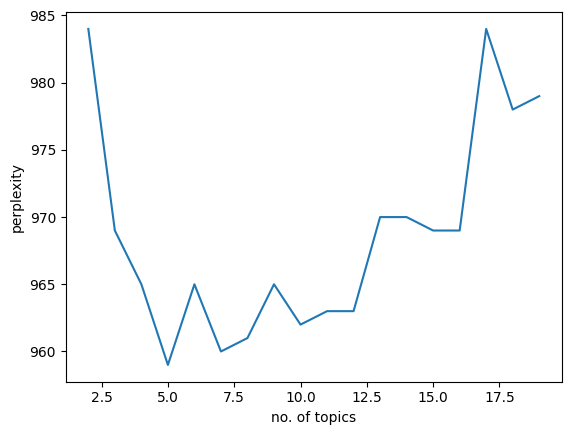

<Figure size 800x600 with 0 Axes>

In [7]:
######plotting the perplexity
import matplotlib.pyplot as plt
perplex= pd.read_csv('PR_perplexities.csv', header=0)
y= perplex['perplexity']
x=perplex['topics']
plt.plot(x, y)
plt.xlabel('no. of topics',fontsize=10)
plt.ylabel('perplexity', fontsize=10)
plt.figure(figsize=(8, 6)) 

In [10]:
Meta= pd.read_csv('PR_meta.csv', header=0, index_col=0)

In [11]:
my_obj.shape

(23153, 1222)

In [12]:
Meta.shape

(1222, 24)

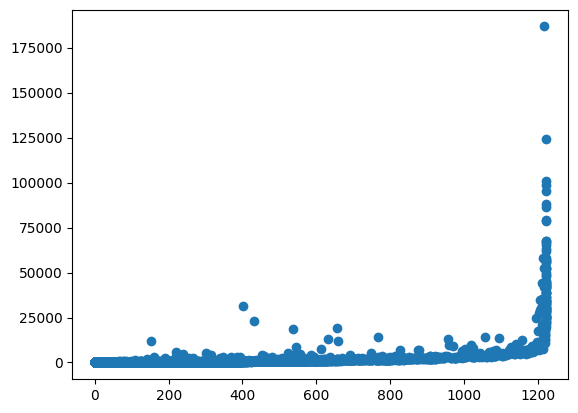

In [9]:
CountsAll= my_obj
plt.plot(CountsAll.astype(bool).sum(axis=1),CountsAll.sum(axis=1),'o')

In [129]:
countsAll= CountsAll
countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]

,AAACGGGCAGACAAAT_SOL008,AAAGATGAGCTTATCG_SOL008,AAAGATGTCGGTTCGG_SOL008,AACTCAGTCAGTGTTG_SOL008,AAGGCAGCATCCGCGA_SOL008,AATCCAGTCCTTCAAT_SOL008,ACACCGGCACGTGAGA_SOL008,ACACTGATCTCCGGTT_SOL008,ACCAGTATCAGCTTAG_SOL008,ACGAGCCGTAGAGGAA_SOL008,...,TTGTAGGAGTTACCCA_SOL016,TTTATGCAGGAGCGAG_SOL016,TTTATGCAGTTAGCGG_SOL016,TTTATGCCATCCGGGT_SOL016,TTTCCTCAGCTTCGCG_SOL016,TTTCCTCGTTGATTCG_SOL016,TTTGGTTAGAACAATC_SOL016,TTTGGTTAGGAACTGC_SOL016,TTTGGTTCATCACGAT_SOL016,TTTGTCAAGTGAACGC_SOL016
FO538757.2,0,0,1,0,0,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
NOC2L,2,1,2,0,1,1,0,1,3,0,...,0,0,0,0,0,0,1,0,0,0
HES4,5,0,3,0,0,0,2,1,3,1,...,0,0,0,1,0,1,0,0,0,0
ISG15,447,29,13,23,11,57,93,16,65,38,...,0,0,3,0,0,0,0,0,0,0
AGRN,5,11,1,2,1,14,1,4,2,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,3,1,1,0,0,1,0,3,0,0,...,0,1,1,1,0,0,2,0,0,0
MT-ND4,103,135,96,49,70,41,31,80,83,30,...,34,23,34,18,1,25,52,41,34,48
MT-ND5,18,13,9,4,2,2,5,11,12,1,...,2,2,3,0,0,2,3,1,3,5
MT-ND6,2,4,0,1,2,3,0,9,7,3,...,0,0,1,0,0,0,1,0,1,0


In [130]:
countsFiltered = countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]


In [131]:
countsFiltered

,AAACGGGCAGACAAAT_SOL008,AAAGATGAGCTTATCG_SOL008,AAAGATGTCGGTTCGG_SOL008,AACTCAGTCAGTGTTG_SOL008,AAGGCAGCATCCGCGA_SOL008,AATCCAGTCCTTCAAT_SOL008,ACACCGGCACGTGAGA_SOL008,ACACTGATCTCCGGTT_SOL008,ACCAGTATCAGCTTAG_SOL008,ACGAGCCGTAGAGGAA_SOL008,...,TTGTAGGAGTTACCCA_SOL016,TTTATGCAGGAGCGAG_SOL016,TTTATGCAGTTAGCGG_SOL016,TTTATGCCATCCGGGT_SOL016,TTTCCTCAGCTTCGCG_SOL016,TTTCCTCGTTGATTCG_SOL016,TTTGGTTAGAACAATC_SOL016,TTTGGTTAGGAACTGC_SOL016,TTTGGTTCATCACGAT_SOL016,TTTGTCAAGTGAACGC_SOL016
FO538757.2,0,0,1,0,0,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
NOC2L,2,1,2,0,1,1,0,1,3,0,...,0,0,0,0,0,0,1,0,0,0
HES4,5,0,3,0,0,0,2,1,3,1,...,0,0,0,1,0,1,0,0,0,0
ISG15,447,29,13,23,11,57,93,16,65,38,...,0,0,3,0,0,0,0,0,0,0
AGRN,5,11,1,2,1,14,1,4,2,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,3,1,1,0,0,1,0,3,0,0,...,0,1,1,1,0,0,2,0,0,0
MT-ND4,103,135,96,49,70,41,31,80,83,30,...,34,23,34,18,1,25,52,41,34,48
MT-ND5,18,13,9,4,2,2,5,11,12,1,...,2,2,3,0,0,2,3,1,3,5
MT-ND6,2,4,0,1,2,3,0,9,7,3,...,0,0,1,0,0,0,1,0,1,0


In [132]:
p = re.compile("RPS|RPL|RP")
list(filter(p.match,countsFiltered.index.values))

['RPL22',
 'RPL11',
 'RPA2',
 'RPS8',
 'RPF1',
 'RPL5',
 'RP11-14N7.2',
 'RPRD2',
 'RPS27',
 'RPS7',
 'RPS27A',
 'RPIA',
 'RPL31',
 'RP11-65I12.1',
 'RPE',
 'RPL37A',
 'RPUSD3',
 'RPL32',
 'RPL15',
 'RPSA',
 'RPL14',
 'RPL29',
 'RPL24',
 'RPN1',
 'RPL22L1',
 'RPL39L',
 'RPL35A',
 'RPL9',
 'RPL34',
 'RP11-83A24.2',
 'RPS3A',
 'RPL37',
 'RPS23',
 'RPS14',
 'RPL26L1',
 'RPS18',
 'RPS10',
 'RPL10A',
 'RPL7L1',
 'RPF2',
 'RPS12',
 'RP11-1275H24.1',
 'RPA3',
 'RP9',
 'RP11-792A8.4',
 'RPS4X',
 'RPL36A',
 'RPL39',
 'RPL10',
 'RPS20',
 'RPL7',
 'RPL30',
 'RPL8',
 'RPS6',
 'RPP25L',
 'RPL35',
 'RPL12',
 'RPL7A',
 'RPLP2',
 'RP11-1391J7.1',
 'RPL27A',
 'RPS13',
 'RPS6KB2',
 'RPS3',
 'RPS25',
 'RPUSD4',
 'RPP38',
 'RPS24',
 'RPP30',
 'RP11-352M15.2',
 'RP11-834C11.4',
 'RPS26',
 'RPL41',
 'RP11-620J15.3',
 'RPL6',
 'RPLP0',
 'RPL21',
 'RPS29',
 'RPL36AL',
 'RP11-532F12.5',
 'RPS27L',
 'RPL4',
 'RPLP1',
 'RPS17',
 'RP11-382A20.3',
 'RPS2',
 'RPS15A',
 'RPL13',
 'RPAIN',
 'RPL26',
 'RPL23A',
 'RP11

In [133]:
countsFiltered = countsFiltered.drop(list(filter(p.match,countsFiltered.index.values)),axis=0)

In [134]:
countsFiltered

,AAACGGGCAGACAAAT_SOL008,AAAGATGAGCTTATCG_SOL008,AAAGATGTCGGTTCGG_SOL008,AACTCAGTCAGTGTTG_SOL008,AAGGCAGCATCCGCGA_SOL008,AATCCAGTCCTTCAAT_SOL008,ACACCGGCACGTGAGA_SOL008,ACACTGATCTCCGGTT_SOL008,ACCAGTATCAGCTTAG_SOL008,ACGAGCCGTAGAGGAA_SOL008,...,TTGTAGGAGTTACCCA_SOL016,TTTATGCAGGAGCGAG_SOL016,TTTATGCAGTTAGCGG_SOL016,TTTATGCCATCCGGGT_SOL016,TTTCCTCAGCTTCGCG_SOL016,TTTCCTCGTTGATTCG_SOL016,TTTGGTTAGAACAATC_SOL016,TTTGGTTAGGAACTGC_SOL016,TTTGGTTCATCACGAT_SOL016,TTTGTCAAGTGAACGC_SOL016
FO538757.2,0,0,1,0,0,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
NOC2L,2,1,2,0,1,1,0,1,3,0,...,0,0,0,0,0,0,1,0,0,0
HES4,5,0,3,0,0,0,2,1,3,1,...,0,0,0,1,0,1,0,0,0,0
ISG15,447,29,13,23,11,57,93,16,65,38,...,0,0,3,0,0,0,0,0,0,0
AGRN,5,11,1,2,1,14,1,4,2,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,3,1,1,0,0,1,0,3,0,0,...,0,1,1,1,0,0,2,0,0,0
MT-ND4,103,135,96,49,70,41,31,80,83,30,...,34,23,34,18,1,25,52,41,34,48
MT-ND5,18,13,9,4,2,2,5,11,12,1,...,2,2,3,0,0,2,3,1,3,5
MT-ND6,2,4,0,1,2,3,0,9,7,3,...,0,0,1,0,0,0,1,0,1,0


In [135]:
referenceCells= Meta[Meta['neigb_class']=='Singlet']

In [136]:
Meta.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_label', 'sample_name',
       'patient_id', 'sample_type', 'sample_site', 'label_short', 'percent.mt',
       'tissue', 'RNA_snn_res.0.35', 'seurat_clusters', 'celltype_hpca',
       'celltype_main', 'celltype_fine', 'ScType_cell', 'refined_celltype',
       'new.clusters', 'final_clusters', 'survival', 'stage', 'neigb_class',
       'neigb_type'],
      dtype='object')

In [137]:
referenceCells.head

<bound method NDFrame.head of                         orig.ident  nCount_RNA  nFeature_RNA   
AAAGATGTCGGTTCGG_SOL008         OV       20486          4285  \
AACTCAGTCAGTGTTG_SOL008         OV       20873          4333   
AAGGCAGCATCCGCGA_SOL008         OV       19809          4056   
AATCCAGTCCTTCAAT_SOL008         OV       11083          2995   
ACACCGGCACGTGAGA_SOL008         OV       18721          4215   
...                            ...         ...           ...   
TTTCCTCGTTGATTCG_SOL016         OV        7331          2205   
TTTGGTTAGAACAATC_SOL016         OV        4422          1314   
TTTGGTTAGGAACTGC_SOL016         OV        3329          1124   
TTTGGTTCATCACGAT_SOL016         OV        5106          1266   
TTTGTCAAGTGAACGC_SOL016         OV        3978          1327   

                                      cell_label sample_name patient_id   
AAAGATGTCGGTTCGG_SOL008  AAAGATGTCGGTTCGG_SOL008      SOL008         P5  \
AACTCAGTCAGTGTTG_SOL008  AACTCAGTCAGTGTTG_SOL008   

In [138]:
#referenceCells.index = [i.replace("-",".") for i in referenceCells.index]

In [139]:
countsFiltered.T

,FO538757.2,NOC2L,HES4,ISG15,AGRN,SDF4,UBE2J2,CPSF3L,MXRA8,AURKAIP1,...,MT-CO1,MT-CO2,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
AAACGGGCAGACAAAT_SOL008,0,2,5,447,5,2,0,1,0,9,...,161,205,103,154,96,3,103,18,2,37
AAAGATGAGCTTATCG_SOL008,0,1,0,29,11,4,3,1,0,9,...,178,195,64,176,84,1,135,13,4,87
AAAGATGTCGGTTCGG_SOL008,1,2,3,13,1,8,0,1,3,6,...,157,91,66,119,59,1,96,9,0,71
AACTCAGTCAGTGTTG_SOL008,0,0,0,23,2,2,0,1,5,6,...,130,60,57,100,44,0,49,4,1,35
AAGGCAGCATCCGCGA_SOL008,0,1,0,11,1,3,4,0,6,7,...,106,74,63,94,57,0,70,2,2,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCCTCGTTGATTCG_SOL016,0,0,1,0,0,3,0,0,1,0,...,52,24,19,47,20,0,25,2,0,25
TTTGGTTAGAACAATC_SOL016,0,1,0,0,0,1,0,0,0,0,...,52,35,53,40,50,2,52,3,1,26
TTTGGTTAGGAACTGC_SOL016,0,0,0,0,0,0,0,0,1,0,...,52,27,21,52,43,0,41,1,0,28
TTTGGTTCATCACGAT_SOL016,0,0,0,0,0,0,0,0,0,0,...,38,21,25,36,31,0,34,3,1,26


In [140]:
referenceCounts= countsFiltered[referenceCells.index]

In [141]:
referenceCounts

,AAAGATGTCGGTTCGG_SOL008,AACTCAGTCAGTGTTG_SOL008,AAGGCAGCATCCGCGA_SOL008,AATCCAGTCCTTCAAT_SOL008,ACACCGGCACGTGAGA_SOL008,ACACTGATCTCCGGTT_SOL008,ACCAGTATCAGCTTAG_SOL008,ACGAGCCGTAGAGGAA_SOL008,ACGATGTGTGTGAAAT_SOL008,ACGCAGCAGCGTCTAT_SOL008,...,TTGGCAAAGTGGTCCC_SOL016,TTTATGCAGGAGCGAG_SOL016,TTTATGCAGTTAGCGG_SOL016,TTTATGCCATCCGGGT_SOL016,TTTCCTCAGCTTCGCG_SOL016,TTTCCTCGTTGATTCG_SOL016,TTTGGTTAGAACAATC_SOL016,TTTGGTTAGGAACTGC_SOL016,TTTGGTTCATCACGAT_SOL016,TTTGTCAAGTGAACGC_SOL016
FO538757.2,1,0,0,2,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
NOC2L,2,0,1,1,0,1,3,0,1,0,...,0,0,0,0,0,0,1,0,0,0
HES4,3,0,0,0,2,1,3,1,1,0,...,3,0,0,1,0,1,0,0,0,0
ISG15,13,23,11,57,93,16,65,38,16,2,...,0,0,3,0,0,0,0,0,0,0
AGRN,1,2,1,14,1,4,2,1,2,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,1,0,0,1,0,3,0,0,1,4,...,0,1,1,1,0,0,2,0,0,0
MT-ND4,96,49,70,41,31,80,83,30,36,51,...,21,23,34,18,1,25,52,41,34,48
MT-ND5,9,4,2,2,5,11,12,1,3,1,...,1,2,3,0,0,2,3,1,3,5
MT-ND6,0,1,2,3,0,9,7,3,0,0,...,0,0,1,0,0,0,1,0,1,0


In [142]:
doubletCells= Meta[Meta['neigb_class']=='Doublet']

In [143]:
doubletCells.head

<bound method NDFrame.head of                         orig.ident  nCount_RNA  nFeature_RNA   
AAACGGGCAGACAAAT_SOL008         OV       21621          4084  \
AAAGATGAGCTTATCG_SOL008         OV       23502          4871   
ACTGATGCACCAACCG_SOL008         OV       24416          4554   
AGCGTATAGGATTCGG_SOL008         OV       22300          4472   
CAGATCATCTAAGCCA_SOL008         OV       18590          4450   
...                            ...         ...           ...   
TGGGCGTAGTACGTTC_SOL016         OV        9199          2264   
TTCCCAGCACAAGCCC_SOL016         OV       23227          3480   
TTGAACGAGTAGATGT_SOL016         OV       18006          4078   
TTGGCAACAAGCGCTC_SOL016         OV        9721          1735   
TTGTAGGAGTTACCCA_SOL016         OV        7476          2064   

                                      cell_label sample_name patient_id   
AAACGGGCAGACAAAT_SOL008  AAACGGGCAGACAAAT_SOL008      SOL008         P5  \
AAAGATGAGCTTATCG_SOL008  AAAGATGAGCTTATCG_SOL008   

In [144]:
doubletsCounts = countsFiltered[doubletCells.index]
doubletsCounts.shape

(5417, 82)

In [145]:
#setting up LDA
singleCellLDA = VariationalLDA(K = 6,alpha = 1,eta=0.005,update_alpha=True)
singleCellLDA.load_data_sc(referenceCounts)
singleCellLDA.run_vb(n_its = 50,initialise=True)

Edited
Initialising
Starting iterations


/tmp/ipykernel_7830/2249788462.py:224: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 11.17487871399819) (9.421612739562988 seconds, I think I'll finish in 7.851343949635823 minutes). Alpha: (45.990983617432505,61.79307097618552)
Iteration 1 (change = 0.006670145110302301) (9.15520691871643 seconds, I think I'll finish in 7.476752316951751 minutes). Alpha: (55.85243105356884,75.25284590657631)
Iteration 2 (change = 0.00619635364182812) (9.407119512557983 seconds, I think I'll finish in 7.5256956100463865 minutes). Alpha: (58.424568436474324,78.79109365818613)
Iteration 3 (change = 0.005940374338241559) (9.694766998291016 seconds, I think I'll finish in 7.594234148661296 minutes). Alpha: (58.958599091652864,79.52203567827348)
Iteration 4 (change = 0.005762637028455643) (9.57030463218689 seconds, I think I'll finish in 7.3372335513432825 minutes). Alpha: (58.926083799117734,79.46659272176468)
Iteration 5 (change = 0.005620244355501412) (9.280680179595947 seconds, I think I'll finish in 6.9605101346969604 minutes). Alpha: (58.73885587600114,79.1950210

In [151]:
topic_dict = pd.DataFrame(singleCellLDA.beta_matrix,index=None).to_dict(orient='index')

In [152]:
scLDA = VariationalLDA(corpus=singleCellLDA.corpus,K=20,
                       word_index=singleCellLDA.word_index,
                       alpha=1,eta=0.0005,update_alpha=True, fixed_topics=topic_dict)

Object created with 1140 documents


In [153]:
wordTopic = pd.DataFrame(singleCellLDA.beta_matrix, columns=referenceCounts.index)

In [154]:
scLDA.load_data_sc(doubletsCounts)

Edited


In [155]:
scLDA.run_vb(n_its=100,initialise=True)

Initialising
Here
Starting iterations


/tmp/ipykernel_7830/2249788462.py:224: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 24.973957573962352) (1.1967692375183105 seconds, I think I'll finish in 1.9946153958638508 minutes). Alpha: (1.8173980289718723,236.62286549702137)
Iteration 1 (change = 3.6837091682153225) (1.0663626194000244 seconds, I think I'll finish in 1.7594983220100402 minutes). Alpha: (1.65065548317106,320.7266755529829)
Iteration 2 (change = 2.7200889386554876) (1.0472617149353027 seconds, I think I'll finish in 1.7105274677276612 minutes). Alpha: (1.519947386703136,353.95718697521374)
Iteration 3 (change = 2.3294998819770676) (1.0409860610961914 seconds, I think I'll finish in 1.6829274654388429 minutes). Alpha: (1.4046786127742448,362.9277894653577)
Iteration 4 (change = 2.197364644423328) (1.0232253074645996 seconds, I think I'll finish in 1.6371604919433593 minutes). Alpha: (1.2738834358187916,359.1243755651679)
Iteration 5 (change = 2.439878168429227) (1.022320032119751 seconds, I think I'll finish in 1.6186733841896057 minutes). Alpha: (1.175802255006249,346.731098

In [156]:
scLDA.beta_matrix.shape

(26, 5417)

In [157]:
scLDA.get_expect_theta().shape

(82, 26)

In [159]:
wordTopicNew = pd.DataFrame(scLDA.beta_matrix, columns=referenceCounts.index)


In [160]:
doubletsCounts.shape

(5417, 82)

In [161]:

interesting_genes = ranking_genes(6,26,scLDA, doubletsCounts.index)

In [162]:
interesting_genes[interesting_genes[3]==18].sort_values(1,ascending=False)[0:20]

,0,1,2,3
275,DAPL1,48,0.695652,[18]
491,EPB41L4A-AS1,42,0.583333,[18]
481,BTF3,41,0.5,[18]
30,MARCKSL1,39,0.619048,[18]
1137,NACA,38,0.463415,[18]
1653,SNRPD2,37,0.45122,[18]
724,NDUFB11,37,0.486842,[18]
1544,NDUFS7,37,0.672727,[18]
818,PABPC1,37,0.45122,[18]
1638,FBL,37,0.480519,[18]


In [164]:
interesting_genes.to_csv('PR_FibCan_genes.csv', index=False)

In [250]:
#interesting_genes= pd.read_csv('B_Can_genes.csv', header=0)


In [165]:
#int_genes = interesting_genes.groupby(0).filter(lambda x: len(x)<10)
int_genes= interesting_genes


In [166]:
final_genes = []
for i in range(7,27):
    g = int_genes[int_genes[3]==i].sort_values([1],ascending=False)[0:20][0].values
    final_genes.append(list(g))

In [167]:
final_genes = [item for sublist in final_genes for item in sublist]

In [168]:
final_genes

['WFDC2',
 'PFN1',
 'CLDN3',
 'SNCG',
 'ATP5I',
 'CD74',
 'RABAC1',
 'SDHA',
 'BHLHE41',
 'ARPC1B',
 'SF3B6',
 'TPM4',
 'DEFB1',
 'REEP5',
 'C19orf52',
 'SPSB3',
 'PRKDC',
 'KLK6',
 'C4orf48',
 'S100A9',
 'LINC00958',
 'S100A14',
 'DPCD',
 'SUCLG2',
 'ATP5D',
 'MCTS1',
 'IGFBP2',
 'MBOAT7',
 'TUBB4B',
 'ERH',
 'LY6E',
 'DAD1',
 'ST13',
 'COX6C',
 'CCT5',
 'S100A11',
 'ATP5G3',
 'ARL2',
 'RSL24D1',
 'SVIP',
 'WFDC2',
 'BST2',
 'IFI27',
 'NDUFS6',
 'PEPD',
 'NDUFA13',
 'CD81',
 'CHCHD10',
 'TPI1',
 'ATP5I',
 'CRIP1',
 'MANF',
 'SLC25A5',
 'TMEM203',
 'UQCRFS1',
 'AURKAIP1',
 'PRDX2',
 'COX7B',
 'PTPRF',
 'PUM2',
 'TM4SF1',
 'ECM1',
 'SHMT2',
 'ACTR10',
 'TAX1BP3',
 'SRSF1',
 'MRPS26',
 'MKKS',
 'ESF1',
 'MMP24-AS1',
 'XRCC6',
 'TMPRSS3',
 'MINOS1',
 'SRSF10',
 'TACSTD2',
 'DEGS1',
 'MRPL55',
 'HADHB',
 'CCDC115',
 'ALKBH2',
 'TUBA1B',
 'KRT8',
 'TUBA1A',
 'SIAH2',
 'MYL12A',
 'HIST1H4C',
 'CYBA',
 'TAGLN',
 'ARID5B',
 'KRT18',
 'TPM4',
 'SF3B6',
 'ACTB',
 'PCNA',
 'PHGDH',
 'S100A11',
 '

In [169]:
len(list(set(final_genes)))

350

In [170]:
final_genes= list(set(final_genes))

In [171]:
print(len(final_genes))
final_genes= pd.DataFrame(final_genes)
#final_genes.to_csv('B_Can_AllGenes.csv')

350


In [172]:
refC = referenceCounts.T.merge(referenceCells,left_index=True,right_index=True)
refC = refC.sort_values(by="seurat_clusters")
refC = refC.drop(referenceCells.columns, axis=1)
allCounts = pd.merge(refC.T,doubletsCounts,left_index=True,right_index=True)
colours = ['blue' if x in refC.index else "red" for x in allCounts.columns]
topicWords = pd.DataFrame(scLDA.beta_matrix,columns=allCounts.index)

In [173]:
from matplotlib.transforms import Bbox
sb.set(font_scale=9)
blue_ref = mpatches.Patch(color="blue", label="reference")
red_dbls = mpatches.Patch(color="red", label="doublets")
legend_TN = [blue_ref, red_dbls]
heatmapCV = sb.clustermap(np.log1p(allCounts.loc[["TNFSF10",
                                                  "FOS","IFI16","ITM2B","ITGB1"]]),row_cluster=False, col_cluster=False, 
               figsize=(80,80),robust=True,cmap='coolwarm',col_colors = colours)

heatmapCV.ax_heatmap.set_xticks([])
heatmapCV.ax_heatmap.set_yticklabels(heatmapCV.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 120)
heatmapCV.ax_heatmap.set_xlabel("Cells",fontsize=200)
heatmapCV.ax_heatmap.set_ylabel("Genes",fontsize=200)
l2 = heatmapCV.ax_heatmap.legend(loc='center right',bbox_to_anchor=(1.40,0.85),handles=legend_TN,frameon=False,
                                fontsize="large")
heatmapCV.cax.set_position(pos=Bbox(np.array([[0.16,0.3],[0.17,0.7]])))
plt.show()


In [174]:
plt.savefig("PR_FibCan.png",dpi=100,bbox_inches="tight")

<Figure size 640x480 with 0 Axes>